# Inference UNet 

**Objectif:** le but de ce notebook est de faire des prédictions sur les images tests en moyennant les modèles et en utilisant le dropout.  

### Root Variables 

In [14]:
import os 

In [15]:
root = '/home/ign.fr/ttea/Code_IGN/AerialImageDataset'
train_dir = os.path.join(root,'train/images')
gt_dir = os.path.join(root,'train/gt')
test_dir = os.path.join(root,'test/images')

In [16]:
import sys 

In [17]:
sys.path.insert(0, '/home/ign.fr/ttea/stage_segmentation_2021/Code')

### Import Libraries 

In [18]:
import numpy as np
import pandas as pd 
%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim

import rasterio
from rasterio.plot import reshape_as_image, reshape_as_raster
import rasterio.mask
from torch.utils.data import Dataset, DataLoader
from rasterio.features import rasterize
from rasterio.windows import Window
from rasterio.crs import CRS
from rasterio.transform import from_origin
from rasterio.merge import merge
from rasterio.plot import show

import glob

from PIL import Image
import albumentations as A
#import monai
#import monai.inferers
#from monai.data.utils import compute_importance_map, dense_patch_slices, get_valid_patch_size
#from monai.utils import BlendMode, PytorchPadMode, fall_back_tuple

In [19]:
from dataloader.dataloader import InriaDataset
from model.model import UNetDropout
from train import train, eval, train_full

In [20]:
var = pd.read_json('variables.json')

## Inria Dataset 

### Tile Image

In [21]:
def read_image(root,filename):
    """
    read image with rasterio and return an array [C, W, H]
    
    no schema/georef returned yet.
    root : root directory 
    filename : image filename as string
    
    Returns: raster as an array 
    """
    img = rasterio.open(os.path.join(root,filename))
    img_array = img.read()
    img.close()
    return img_array

# Dataset

In [22]:
tile_size = (256,256)
train_dataset = InriaDataset(var['variables']['root'],tile_size,'train',None,False,1)
val_dataset = InriaDataset(var['variables']['root'],tile_size,'validation',None,False,1)

In [23]:
train_dataloader = DataLoader(train_dataset, 4, num_workers=6,  drop_last=True, shuffle=True)
val_dataloader = DataLoader(val_dataset, 4, num_workers=6, drop_last=True)

In [24]:
train_dataset_hflip = InriaDataset(root, tile_size, 'train', 'HorizontalFlip', False,1)
train_dataset_vflip = InriaDataset(root, tile_size, 'train', 'VerticalFlip', False,1)
train_dataset_rot = InriaDataset(root, tile_size, 'train', 'Rotation90', False,1)

In [25]:
hparam = {
    'lr':0.0001,
    'n_epoch':40,
    'n_epoch_test':int(5),
    'n_class':2,
    'batch_size':8,
    'n_channel':3,
    'conv_width':[16,32,64,128,256,128,64,32,16],
}

In [28]:
tile_size = (512,512)

weights = [0.5, 1.0]
class_weights = torch.FloatTensor(weights).cuda()

args = {
    #'nn_loss':nn.BCEWithLogitsLoss(reduction="mean"),
    'nn_loss':nn.CrossEntropyLoss(weight = class_weights,reduction="mean"),
    #'loss_name': 'BinaryCrossentropy',
    'loss_name': 'Crossentropy',
    'threshold':0.5,
    'cuda':1,
    'class_names':['None','Batiment'],
    'save_model':False,
    'save_model_name':"unet_CEdropout_8_1.pth",
    'train_dataset':InriaDataset(var['variables']['root'],tile_size,'train',None,False,1),
    'val_dataset':InriaDataset(var['variables']['root'],tile_size,'validation',None,False,1),
}

## Training Model with Dropout 

In [30]:
model = UNetDropout(hparam['n_channel'], hparam['conv_width'], hparam['n_class'], cuda=args['cuda'])
#trained_model, metrics_train, metrics_test = train_full(args, model,hparam['lr'],hparam['n_epoch'],
#                                    hparam['n_epoch_test'],hparam['batch_size'],hparam['n_class'],
#                                    hparam['n_channel'])

In [31]:
def apply_dropout(m):
    if type(m) == nn.Dropout:
        m.train()

## Loading Model with Dropout

On charge le modèle qui est déjà pré-entraîné pour pouvoir l'utiliser pour l'inférence.

In [32]:
model = UNetDropout(hparam['n_channel'], hparam['conv_width'], hparam['n_class'], cuda=args['cuda'])

save_model = '/home/ign.fr/ttea/Code_IGN/Data/model_save/unet_CEdropout_8_1.pth'
model.load_state_dict(torch.load(save_model))
model.apply(apply_dropout)

UNetDropout(
  (c1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (p1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (p2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (p3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c4): Sequential(
    (0): Conv2d(64, 128, kern

### Inference Method

La fonction predictor_arg va retourner l'indice de la plus grande valeur dans le tenseur. 

La fonction inference prends en entrée :
- le chemin de l'image
- la taille de la tuile 
- prédicteur
- dossier de sortie 

Retourne : Ecrit la prédiction dans une numpy array. 

Les étapes sont : 
- Ouverture du fichier avec rasterio 
- Initialisation du masque ou l'on va écrire la prédiction 
- Pour chaque tuile on va faire une prédiction puis l'écrire 
- On retourne la numpy array finale qui contient la prédiction de l'image 

In [33]:
def predictor_arg(tensor):
    return model(tensor).argmax(1) 

def inference_roi(path_image,roi_size,predictor,output_dir):
    
    # open image with rasterio 
    img =  rasterio.open(os.path.join(path_image))
    height = img.height
    width = img.width
    
    nb_col = width // roi_size[0]
    nb_row = height // roi_size[1]
    
    base=os.path.basename(path_image)
    base_without_ex = os.path.splitext(base)[0]

    profile = img.profile.copy()

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        driver = "GTiff",
        height = height,
        width = width,
        compress='lzw')

    img_transform = img.transform
    
    # Initialisation 
    mask =  np.zeros((1,width, height))
    
    shp_width = np.shape(mask)[1]
    shp_height = np.shape(mask)[2]
    
    with torch.no_grad(): 
        for col in range(0,nb_col):
            for row in range(0,nb_row):
                
                tile = img.read(window=Window(col*roi_size[0],row*roi_size[1],roi_size[0],roi_size[1]))
                tile_tensor = torch.from_numpy(tile).float()
                pred = predictor(tile_tensor.unsqueeze(dim=0))
                pred_cm = pred.cpu().detach().numpy()
                
                # Affiche Rvb & Mask 
                #show(tile)
                #show(pred_cm)
                
                mask[:,row*roi_size[1]:(row+1)*roi_size[1],col*roi_size[0]:(col+1)*roi_size[0]] = pred_cm.astype(np.uint8)
                
                # Cas unique dernière tile en diagonale
                if (col == nb_col -1) and (row == nb_row -1):
                    tile = img.read(window=Window( shp_width - roi_size[0], shp_height - roi_size[1],roi_size[0],roi_size[1]))
                    tile_tensor = torch.from_numpy(tile).float()
                    pred = predictor(tile_tensor.unsqueeze(dim=0))
                    pred_cm = pred.cpu().detach().numpy()
                    mask[:,shp_height - roi_size[0] :,shp_width - roi_size[1]:] = pred_cm.astype(np.uint8)
                    
                
                # Dernière Row -> Recouvrement
                if row == nb_row -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window(col*roi_size[0],shp_height - roi_size[0],roi_size[0],roi_size[1]))
                    tile_tensor = torch.from_numpy(tile).float()
                    pred = predictor(tile_tensor.unsqueeze(dim=0))
                    pred_cm = pred.cpu().detach().numpy()
                    mask[:,shp_height - roi_size[1]:,col*roi_size[0]:(col+1)*roi_size[0]] = pred_cm.astype(np.uint8)
                
                # Dernière Col -> Recouvrement 
                if col == nb_col -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window( shp_width - roi_size[0], row*roi_size[1] ,roi_size[0],roi_size[1]))
                    tile_tensor = torch.from_numpy(tile).float()
                    pred = predictor(tile_tensor.unsqueeze(dim=0))
                    pred_cm = pred.cpu().detach().numpy()
                    mask[:,row*roi_size[1]:(row+1)*roi_size[1],shp_height - roi_size[0]:] = pred_cm.astype(np.uint8)
                    
        # Profile update (transformation)
        x,y = rasterio.transform.xy(img_transform, nb_col*roi_size[0],nb_row*roi_size[1])
        out_transform = rasterio.transform.from_origin(x,y,nb_col*roi_size[0],nb_row *roi_size[1]) 
        out_tile_name = os.path.join(output_dir,f'{base_without_ex}_{nb_col:02}_{nb_row:02}_predfinal.tif')
        profile.update(transform = out_transform)
        
        # Plot mask 
        mask = mask.astype(np.uint8)
        show(mask)
        
        with rasterio.open(out_tile_name,"w",**profile) as dst : 
            dst.write(mask)

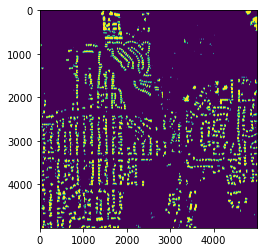

In [34]:
# inference parameter 
predictor = predictor_arg
roi_size = (256,256)

list_img = os.listdir(test_dir)
path_image = os.path.join(test_dir,list_img[2])
output_dir = r'/home/ign.fr/ttea/Code_IGN/Data/output'

inference_roi(path_image,roi_size,predictor,output_dir)

### Inference with Batch

In [35]:
def inference_roi_batch(path_image,roi_size,predictor,output_dir,batch_size):
    
    # open image with rasterio 
    img =  rasterio.open(os.path.join(path_image))
    height = img.height
    width = img.width
    
    nb_col = width // roi_size[0]
    nb_row = height // roi_size[1]
    
    base=os.path.basename(path_image)
    base_without_ex = os.path.splitext(base)[0]

    profile = img.profile.copy()

    # And then change the band count to 1, set the
    # dtype to uint8, and specify LZW compression.
    profile.update(
        dtype=rasterio.uint8,
        count=1,
        driver = "GTiff",
        height = height,
        width = width,
        compress='lzw')

    img_transform = img.transform
    
    # Initialisation 
    mask =  np.zeros((1,width, height))
    
    
    
    n = True
    
    shp_width = np.shape(mask)[1]
    shp_height = np.shape(mask)[2]
    
    with torch.no_grad(): 
        for col in range(0,nb_col):
            for row in range(0,nb_row):
                
                pred_list = []
                
                tile = img.read(window=Window(col*roi_size[0],row*roi_size[1],roi_size[0],roi_size[1]))
                # Dupplique la taille par rapport au nombre de batch (1,nb canaux, roi size, roi size) -> (batch_size, nb canaux, roi size, roi size)
                tile = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)
                tile_tensor = torch.from_numpy(tile).float()
                
                for i in range(batch_size):
                    #pred = predictor(tile_tensor.unsqueeze(dim=0))
                    pred = predictor(tile_tensor[i].unsqueeze(dim=0))
                    pred_cm = pred.cpu().detach().numpy()          
                    pred_list.append(pred_cm)
                
                pred_avg = sum(pred_list) / 4
                    
                # Affiche Rvb & Mask 
                #show(tile)
                #show(pred_cm)
                
                mask[:,row*roi_size[1]:(row+1)*roi_size[1],col*roi_size[0]:(col+1)*roi_size[0]] = pred_avg.astype(np.uint8)
                
                # Cas unique dernière tile en diagonale
                if (col == nb_col -1) and (row == nb_row -1):
                    tile = img.read(window=Window( shp_width - roi_size[0], shp_height - roi_size[1],roi_size[0],roi_size[1]))
                    tile = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)
                    tile_tensor = torch.from_numpy(tile).float()
                    
                    for i in range(batch_size):
                        pred = predictor(tile_tensor[i].unsqueeze(dim=0))
                        pred_cm = pred.cpu().detach().numpy()
                        pred_list.append(pred_cm)
                    
                    pred_avg = sum(pred_list) / 4
                    
                    mask[:,shp_height - roi_size[0] :,shp_width - roi_size[1]:] = pred_avg.astype(np.uint8)
                        
                # Dernière Row -> Recouvrement
                if row == nb_row -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window(col*roi_size[0],shp_height - roi_size[0],roi_size[0],roi_size[1]))
                    tile = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)
                    tile_tensor = torch.from_numpy(tile).float()
                    
                    for i in range(batch_size):
                        pred = predictor(tile_tensor[i].unsqueeze(dim=0))
                        pred_cm = pred.cpu().detach().numpy()
                        pred_list.append(pred_cm)
                        
                    pred_avg = sum(pred_list) / 4
                    
                    mask[:,shp_height - roi_size[1]:,col*roi_size[0]:(col+1)*roi_size[0]] = pred_avg.astype(np.uint8)
                    
                # Dernière Col -> Recouvrement 
                if col == nb_col -1:
                    # window argument : taille height, width image
                    tile = img.read(window=Window( shp_width - roi_size[0], row*roi_size[1] ,roi_size[0],roi_size[1]))
                    tile = np.repeat(tile[np.newaxis,:, :,: ], batch_size, axis=0)
                    tile_tensor = torch.from_numpy(tile).float()
                    
                    for i in range(batch_size):
                        pred = predictor(tile_tensor[i].unsqueeze(dim=0))
                        pred_cm = pred.cpu().detach().numpy()
                        pred_list.append(pred_cm)
                        
                    pred_avg = sum(pred_list) / 4
                    
                    mask[:,row*roi_size[1]:(row+1)*roi_size[1],shp_height - roi_size[0]:] = pred_avg.astype(np.uint8)
                    
        # Profile update (transformation)
        x,y = rasterio.transform.xy(img_transform, nb_col*roi_size[0],nb_row*roi_size[1])
        out_transform = rasterio.transform.from_origin(x,y,nb_col*roi_size[0],nb_row *roi_size[1]) 
        out_tile_name = os.path.join(output_dir,f'{base_without_ex}_{nb_col:02}_{nb_row:02}_predfinal.tif')
        profile.update(transform = out_transform)
        
        # Plot mask 
        mask = mask.astype(np.uint8)
        show(mask)
        
        with rasterio.open(out_tile_name,"w",**profile) as dst : 
            dst.write(mask)

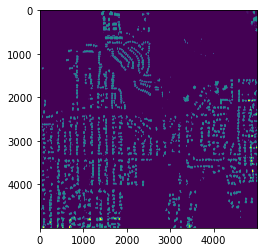

In [36]:
# inference parameter 
predictor = predictor_arg
roi_size = (256,256)
batch_size = 4

list_img = os.listdir(test_dir)
path_image = os.path.join(test_dir,list_img[2])
output_dir = r'/home/ign.fr/ttea/Code_IGN/Data/output'

inference_roi_batch(path_image,roi_size,predictor,output_dir,batch_size)

https://github.com/albumentations-team/albumentations_examples

https://medium.com/@ArjunThoughts/albumentations-package-is-a-fast-and-%EF%AC%82exible-library-for-image-augmentations-with-many-various-207422f55a24

Si l'on souhaite prédire toutes les images dans la liste des images.

In [37]:
#for img in list_img:
#    path_image = os.path.join(test_dir,img)
#    inference_roi(path_image,roi_size,predictor,output_dir)